**--------------------------------------------------------------------------------------------------------------------------------------------------------------**


# Question 1 (2 Marks)
## Download the fashion-MNIST dataset and plot 1 sample image for each class as shown in the grid below. Use from keras.datasets import fashion_mnist for getting the fashion mnist dataset.

**--------------------------------------------------------------------------------------------------------------------------------------------------------------**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import fashion_mnist

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


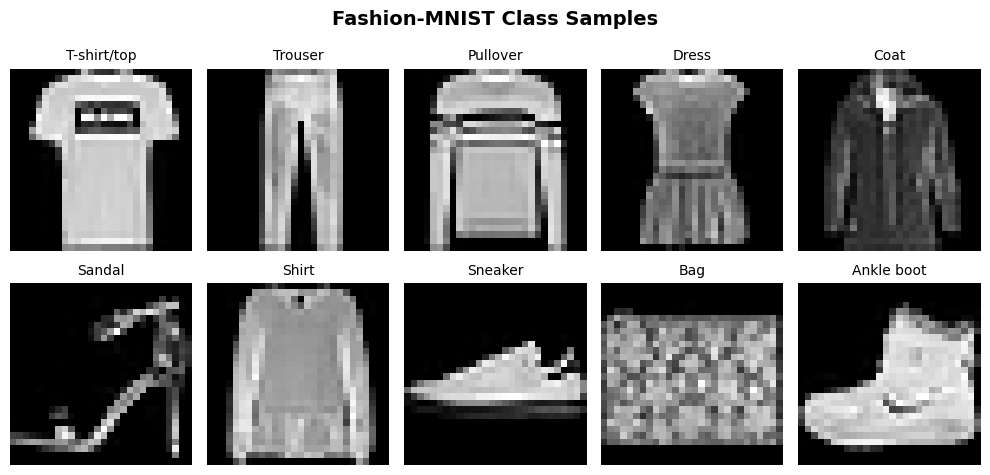

In [2]:
"""Class to load and preprocess the Fashion-MNIST dataset."""
class FashionMNISTLoader:

    def __init__(self):
        (self.x_train, self.y_train), (_, _) = fashion_mnist.load_data()
        self.class_labels = [
            'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
            'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
        ]

    def get_sample_images(self):
        sample_images = []
        for label in range(10):
            idx = np.where(self.y_train == label)[0][0]
            sample_images.append((self.x_train[idx], self.class_labels[label]))
        return sample_images

class ImagePlotter:

    @staticmethod
    def plot_images(image_data):
        fig, axes = plt.subplots(2, 5, figsize=(10, 5))
        fig.suptitle("Fashion-MNIST Class Samples", fontsize=14, fontweight='bold')

        for ax, (image, label) in zip(axes.flat, image_data):
            ax.imshow(image, cmap='gray')
            ax.set_title(label, fontsize=10)
            ax.axis('off')

        plt.tight_layout()
        plt.show()

class FashionMNISTVisualizer:
    def __init__(self):
        self.data_loader = FashionMNISTLoader()
        self.plotter = ImagePlotter()

    def visualize_samples(self):
        samples = self.data_loader.get_sample_images()
        self.plotter.plot_images(samples)

if __name__ == "__main__":
    visualizer = FashionMNISTVisualizer()
    visualizer.visualize_samples()


**--------------------------------------------------------------------------------------------------------------------------------------------------------------**



# Question 2 (10 Marks)
## Implement a feedforward neural network which takes images from the fashion-mnist data as input and outputs a probability distribution over the 10 classes. Your code should be flexible such that it is easy to change the number of hidden layers and the number of neurons in each hidden layer.

**Preprocessing code**

**--------------------------------------------------------------------------------------------------------------------------------------------------------------**

In [4]:
'''
This code defines classes for one-hot encoding labels, normalizing input features, and splitting data into training and validation sets,
which are essential steps in preprocessing for machine learning tasks. Each class handles a specific transformation to prepare data for
model training and evaluation.
'''
import numpy  as np

class OneHotEncoder:

    def __init__(self,x, y):
        self.y = y
        self.x = x
        #self.num_class = num_class
        self.onehot_encode()

    def onehot_encode(self):
        onehot = np.zeros((self.x.shape[0], 10))

        for i, j in zip(range(len(self.x)), self.y):
            onehot[i, j] = 1
        return onehot.T

class Normalize:

    def __init__(self, unprocessed_X):
        self.unprocessed_X = unprocessed_X
        self.Norm_reshape()

    def Norm_reshape(self):
        X_norm = np.reshape(self.unprocessed_X,(self.unprocessed_X.shape[0],784)).T/255
        X_norm= np.array(X_norm)

        return X_norm


class TrainValSplit:
  def __init__(self, X_train, y_train, Val_split_ratio = 0.9):
    self.X = X_train
    self.y = y_train
    self.vsr = Val_split_ratio

  def Apply_split(self):
    np.random.seed(0)

    i = np.random.permutation(len(self.X))
    split = int(self.X.shape[0] * (1 - self.vsr))

    train = i[:split]
    val = i[split:]

    train_X = self.X[train]
    val_X = self.X[val]

    train_y = self.y[train]
    val_y = self.y[val]

    return train_X , train_y, val_X, val_y

**Activation functions and their gradient calculation code**

In [70]:
import numpy as np

class CalActivation:
    def __init__(self, m):
        self.m = m

# Sigmoid (for hidden layers)
class sigmoid(CalActivation):
    def use_sigmoid(self):
        return 1 / (1 + np.exp(-np.clip(self.m, -250, 250)))  # Clip inputs

    def sigmoid_d(self):
        sig = self.use_sigmoid()
        return sig * (1 - sig)


class relu(CalActivation):
    def use_relu(self):
        return np.maximum(0, self.m)

    def relu_d(self):
        return np.where(self.m > 0, 1, 0)

class Leakyrelu(CalActivation):
    def use_relu(self):
        return np.maximum(0, self.m)

    def relu_d(self):
        return np.where(self.m > 0, 1, 0.01)


class softmax(CalActivation):
    def use_softmax(self):
        shifted = self.m - np.max(self.m, axis=0, keepdims=True)
        exps = np.exp(shifted)
        return exps / np.sum(exps, axis=0, keepdims=True)

    def softmax_d(self):
        z=self.m - np.max(self.m,axis=0)
        soft=np.exp(z)/np.sum(np.exp(z),axis=0)
        return soft*(1-soft)

class tanh(CalActivation):
    def use_tanh(self):
        return np.tanh(self.m)  # Built-in is stable

    def tanh_d(self):
        return 1 - (self.use_tanh() ** 2)




# This function call different activation function
class apply_activation(CalActivation):

    def __init__(self, activation_function, m):
        super().__init__(m)
        self.activation_function = activation_function.lower()

    def do_activation(self):
        if self.activation_function == 'sigmoid':
            return sigmoid(self.m).use_sigmoid()
        elif self.activation_function == 'relu':
            return relu(self.m).use_relu()
        elif self.activation_function == 'lrelu':
            return Leakyrelu(self.m).use_relu()
        elif self.activation_function == 'tanh':
            return tanh(self.m).use_tanh()
        elif self.activation_function == 'softmax':
            return softmax(self.m).use_softmax()

    def do_activation_derivative(self):
        if self.activation_function == 'sigmoid':
            return sigmoid(self.m).sigmoid_d()
        elif self.activation_function == 'relu':
            return relu(self.m).relu_d()
        elif self.activation_function == 'lrelu':
            return Leakyrelu(self.m).relu_d()
        elif self.activation_function == 'tanh':
            return tanh(self.m).tanh_d()
        elif self.activation_function == 'softmax':
            return softmax(self.m).softmax_d()
        else:
           raise ValueError("Unknown activation function")


**Initilization of weights and biases code using Xavier / He / Random**

In [56]:
import numpy as np

class Initilize:
    def __init__(self, layer_dimension, activation_function, y_train, method = "Xavier_U"):
        self.n = layer_dimension
        self.activation_fn = activation_function
        self.y = y_train
        self.Init_method = method

class InitializeWeights(Initilize):
    def __init__(self, ip_size, op_size, activation_function, batch_size, method):
        super().__init__([ip_size, op_size], activation_function, batch_size, method)  # Properly inherit Initilize attributes
        self.i_size = ip_size
        self.o_size = op_size
        self.Init_weights()


    def Init_weights(self):
        np.random.seed(0)

        if self.Init_method == "Xavier_N":
          np.random.seed(0)
          a = np.sqrt(1 / self.i_size)
          self.weight = np.random.randn(self.o_size,self.i_size)*a

        elif self.Init_method == "Xavier_U":
          np.random.seed(0)
          a = np.sqrt(6 / (self.o_size + self.i_size))
          self.weight = np.random.uniform((-a), a,( self.o_size,self.i_size))

        elif self.Init_method == "He_N":
          np.random.seed(0)
          a = np.sqrt(2 / self.i_size)
          self.weight = np.random.randn(self.o_size,self.i_size)*a

        elif self.Init_method == "He_U":
          np.random.seed(0)
          a = np.sqrt(6 / self.i_size)
          self.weight = np.random.uniform(-a, a, (self.o_size,self.i_size))

        elif self.Init_method == "Random":
          np.random.seed(0)
          self.weight = np.random.randn(self.o_size,self.i_size)*0.01
        else:
          raise ValueError(f"Unknown initialization method: {self.Init_method}")


        # Initialize biases and activations
        self.bias = np.zeros((self.o_size, 1))
        self.a = np.zeros((self.o_size, len(self.y[1])))
        self.h = np.zeros((self.o_size, len(self.y[1])))

        # Activation function and its derivative
        self.g = apply_activation(self.activation_fn, self.a).do_activation()
        self.d_g = apply_activation(self.activation_fn, self.a).do_activation_derivative()

        # Gradients
        self.d_a = np.zeros_like(self.a)
        self.d_h = np.zeros_like(self.h)
        self.d_w = np.zeros_like(self.weight)
        self.d_b = np.zeros_like(self.bias)
        self.Weight_updates = np.zeros_like(self.weight)
        self.bias_updates = np.zeros_like(self.bias)



class Weight_bias(Initilize):
    def __init__(self, layer_dimension, activation_function, y_train, method="Xavier_U"):
        super().__init__(layer_dimension, activation_function, y_train, method)
        self.network = []


    def Init_network(self):

        for i in range(1, len(self.n)):
          self.network.append(InitializeWeights( self.n[i-1], self.n[i], self.activation_fn[i-1], self.y, self.Init_method))

        return self.network


**Feedforward Code for Prediction**

In [57]:

class Pre_Feedforward:

  def __init__(self, inputs, w, b, activation_fn):
    self.ip= inputs
    self.w = w
    self.b = b
    self.activation_fn = activation_fn
    self.Preactivation_cal()


  def Preactivation_cal(self):

    A = np.dot(self.w, self.ip) + self.b
    A_norm = (A - np.mean(A, axis=1, keepdims=True)) / np.std(A, axis=1, keepdims=True) #Activation Normalization
    H = apply_activation(self.activation_fn, A_norm).do_activation()
    #cache = (H, A)
    #self.cache["Input"] = self.Prev_layer_H
    #self.cache["Pre_act"] = H
    return A , H

class Feedforward:

  def __init__(self,X_train, activation_fn, method, network):
    self.input = X_train
    self.activation_fn = activation_fn
    self.method = method
    self.network = network

  def Forward_prop(self):

    L = len(self.network)
    # print(L)

    for i in range(L):
      # print(i)
      # print("oth layer input" , self.input.shape)

      self.network[i].a, self.network[i].h = Pre_Feedforward(self.input, self.network[i].weight, self.network[i].bias, self.activation_fn[i]).Preactivation_cal()
      self.input = self.network[i].a
      # print("oth layer w" , a[i].weight.shape)
      # print("oth layer b" , a[i].bias.shape)
      # print("oth layer h" , a[i].h.shape)
      # print("oth layer a" , a[i].a.shape)


    return self.network


In [58]:
from keras.datasets import fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_new= Normalize(X_train).Norm_reshape()
y_new =OneHotEncoder(X_train,y_train).onehot_encode()

 **Here is the answer of question 2 where we have to predict the output of 10 class in probability disturbution form**

In [59]:
'''
Initialise the network with Xavier Uniform initilised weight and biases
'''

Initial_network = Weight_bias(layer_dimension = [784, 128, 64, 10],
                              activation_function = ['sigmoid','relu','softmax'],
                              y_train = y_new,
                              method = "Xavier_U").Init_network()

'''
Predicting the output of 10 class with Xavier Uniform initilised weight and biases
'''

Predict = Feedforward(X_train = X_new,
                     activation_fn= ['sigmoid','relu','softmax'],
                     method = "Xavier_U",
                     network= Initial_network).Forward_prop()


print(" Here is the prediction of output of 10 class in probability disturbution form \n with Xavier Uniform initilised weight and biases: \n\n", Predict[2].h)

 Here is the prediction of output of 10 class in probability disturbution form 
 with Xavier Uniform initilised weight and biases: 

 [[0.12972934 0.02736321 0.05606109 ... 0.02924843 0.13919559 0.28173024]
 [0.08958929 0.10297096 0.09014636 ... 0.05940065 0.04886422 0.07818933]
 [0.0826621  0.25909435 0.15104963 ... 0.21367701 0.08127471 0.02110413]
 ...
 [0.24521651 0.17669521 0.11148419 ... 0.03436621 0.05244138 0.01646606]
 [0.05550834 0.21928251 0.08714714 ... 0.15697124 0.05925401 0.05232998]
 [0.20670031 0.04619039 0.04105517 ... 0.00847484 0.07039559 0.03174267]]


**--------------------------------------------------------------------------------------------------------------------------------------------------------------**


#Question 3 (24 Marks)
##Implement the backpropagation algorithm with support for the following optimisation functions

##sgd
##momentum based gradient descent
##nesterov accelerated gradient descent
##rmsprop
##adam
##nadam (Not required as aked)
##We will check the code for implementation and ease of use (e.g., how easy it is to add a new optimisation algorithm such as Eve). Note that the code should be flexible enough to work with different batch sizes.

**--------------------------------------------------------------------------------------------------------------------------------------------------------------**

**L2 / L1 Norm Regularization Code and their Gradient Calling functions :**

In [60]:
import numpy as np

class Regularisation:
    def __init__(self, network, weight=0):
        self.network = network
        self.weight = weight

class L2_regularisation(Regularisation):
    def Apply_L2(self):
        """Returns L2 regularization loss for the given network."""
        L = len(self.network)
        res = 0
        for j in range(L):
            if np.isnan(self.network[j].weight).any():
                print(f"Warning: NaN detected in network weights at layer {j}")
                return 0
            res += 0.5 * np.sum(self.network[j].weight ** 2)
        return res

    def Apply_L2_grad(self, weight):
        """Returns L2 regularization gradient for the given weight matrix/tensor."""
        return 2 * weight

class L1_regularisation(Regularisation):
    def Apply_L1(self):
        """Returns L1 regularization loss for the given network."""
        L = len(self.network)
        res = 0
        for j in range(L):
            if np.isnan(self.network[j].weight).any():
                print(f"Warning: NaN detected in network weights at layer {j}")
                return 0
            res += (1 / 2) * np.sum(np.abs(self.network[j].weight))
        return res

    def Apply_L1_grad(self, weight):
        """Returns L1 regularization gradient for the given weight matrix/tensor."""
        return np.sign(weight)

class ApplyReg(Regularisation):
    def __init__(self, reg_function, network, weight=0):
        self.reg_function = reg_function
        super().__init__(network, weight)

    def do_reg(self):
        if self.reg_function == 'L2':
            return L2_regularisation(self.network).Apply_L2()
        if self.reg_function == 'L1':
            return L1_regularisation(self.network).Apply_L1()
        if self.reg_function == 'L2_d':
            return L2_regularisation(self.network).Apply_L2_grad(self.weight)
        if self.reg_function == 'L1_d':
            return L1_regularisation(self.network).Apply_L1_grad(self.weight)


**Overall Loss and Accuracy Calling functions code :**

In [61]:
class CalculateAllLoss:
  def __init__(self, X_train, y_predicted,network, y_train, primary_loss, weight_decay=0, regularisation_fn=None):
    self.y_predicted = y_predicted
    self.y_true = y_train
    self.network = network
    self.X_train = X_train
    self.loss_value = primary_loss
    self.weight_decay = weight_decay
    self.regularisation_fn= regularisation_fn
    self.calc_accuracy_loss()


  def overall_loss(self):
    """
    Calculates the total loss of the network.
    - Total loss value.
    """

    total_loss = self.loss_value

    if self.weight_decay > 0 and self.regularisation_fn:
        regularized_val = ApplyReg(self.regularisation_fn, self.network).do_reg()
        print(f"Reg value: {regularized_val}")
        total_loss += self.weight_decay * regularized_val
    return total_loss




  def calc_accuracy_loss(self):
    """
    Computes the accuracy and loss for a given neural network.
    """

    total_loss = self.loss_value

    if self.weight_decay > 0 and self.regularisation_fn:
        regularized_val = ApplyReg(self.regularisation_fn, self.network).do_reg()
        print(f"Reg value: {regularized_val}")
        total_loss += self.weight_decay * regularized_val


    assert self.X_train.shape[1] == self.y_true.shape[1], "Mismatch in batch size between inputs and labels"


    batch_size = self.X_train.shape[1]
    correct_predictions = np.sum(np.argmax(self.y_predicted, axis=0) == np.argmax(self.y_true, axis=0))

    accuracy = correct_predictions / batch_size

    return accuracy , total_loss



**All Loss functions and their Gradient Calling functions code :**

In [62]:
import numpy as np

class CalLoss:
    def __init__(self, y, y_pred):
        self.y = y
        self.y_predicted = y_pred
        if y.shape != y_pred.shape:
            raise ValueError(f"Shape mismatch: y shape is {self.y.shape}, y_predicted shape is {self.y_predicted.shape}")

class CrossEntropy(CalLoss):
    def give_celoss(self):
        epsilon = 1e-8  # Small value to prevent log(0)
        return -np.mean(self.y * np.log(self.y_predicted + epsilon))

    def Give_cegrad(self):
        epsilon = 1e-8  # Prevent division by zero
        grad = -self.y / (self.y_predicted + epsilon)
        return grad

class SquaredError(CalLoss):
    def give_seloss(self):
        return np.mean((self.y - self.y_predicted) ** 2)

    def Give_segrad(self):
        grad = -2 * (self.y - self.y_predicted)
        return np.clip(grad, -1, 1)  # Clip to prevent exploding gradients

class callloss(CalLoss):
    def __init__(self, loss_function, y, y_pred):
        self.loss_function = loss_function.lower()
        super().__init__(y, y_pred)

    def give_loss(self):
        if self.loss_function == 'ce':
            return CrossEntropy(self.y, self.y_predicted).give_celoss()
        elif self.loss_function == 'se':
            return SquaredError(self.y, self.y_predicted).give_seloss()
        else:
            raise ValueError(f"Unknown loss function: {self.loss_function}")

    def give_gradloss(self):
        if self.loss_function == 'ce':
            return CrossEntropy(self.y, self.y_predicted).Give_cegrad()
        elif self.loss_function == 'se':
            return SquaredError(self.y, self.y_predicted).Give_segrad()
        else:
            raise ValueError(f"Unknown loss function: {self.loss_function}")


####Below we have the answers of question 3 : Proper Backprop code and along with that we ahve all 5 optimiser codes

**Backpropagation codes which returns the network :**

In [63]:
from tqdm import tqdm
import math

class Backpropagation:

    def __init__(self, loss_function, X_train, y_train, y_pred, network, weight_decay, batch, batch_size, activation_fn):
        self.loss_function = loss_function
        self.X_train = X_train
        self.y_train = y_train
        self.y_predicted = y_pred
        self.network = network
        self.weight_decay = weight_decay
        self.batch = batch
        self.batch_size = batch_size
        self.activation_fn = activation_fn


    def backward_propagation(self):
      L = len(self.network)

      assert(self.y_train.shape[1] == self.y_predicted.shape[1])


      self.network[-1].d_a = callloss(self.loss_function,self.y_train, self.y_predicted).give_gradloss()
      # print("network -[-1].d_a : " , self.network[-1].d_a.shape)
      A_k = apply_activation(self.activation_fn[-1], self.network[-1].h).do_activation_derivative()
      # print("shape A_ k : " , A_k.shape)
      self.network[-1].d_h = self.network[-1].d_a * A_k
      # print("network -[-1].d_h : " , self.network[-1].d_a.shape)

      self.network[-1].d_w = self.network[-1].d_h @ self.network[-2].a.T  + self.weight_decay * self.network[-1].weight
      # print("network -[-1].d_w : " , self.network[-1].d_w.shape)
      d_b = -np.sum(self.network[-1].d_h, axis = 1)
      self.network[-1].d_b = d_b.reshape(-1 , 1)
      # print("network -[-1].d_b : " , self.network[-1].d_b.shape)



      for k in range(L-2,0,-1):
          # print(f"No of layers rotation {k}")

          self.network[k].d_h = self.network[k + 1].weight.T @ self.network[k + 1].d_a
          # print(f"shape self.network-{k}.d_h : " , self.network[k].d_h.shape)
          act_derv =  apply_activation(self.activation_fn[k], self.network[k].a)
          self.network[k].d_a = self.network[k].d_h * act_derv.do_activation_derivative()
          # print(f"shape self.network-{k}.d_a : " , self.network[k].d_a.shape)

          self.network[k].d_w = self.network[k].d_a @ self.network[k-1].h.T  + self.weight_decay * self.network[k].weight
          # print(f"shape self.network-{k}.d_w : " , self.network[k].d_w.shape)
          derv_bias = -np.sum(self.network[k].d_a, axis=1)
          self.network[k].d_b = derv_bias.reshape(-1 , 1)
          # print(f"shape self.network-{k}.d_b : " , self.network[k].d_b.shape)

      # print(f"shape self.network-{0}.d_a : " , self.network[0].d_a.shape)
      d_a = self.network[0].d_a[:, self.batch*self.batch_size : (self.batch+1)*self.batch_size]
      # print(f"shape self.network-{0}.d_a : " , d_a.shape)
      self.network[0].d_w = np.dot(d_a , self.X_train.T) + self.weight_decay * self.network[0].weight
      # print("network -[0].d_w : " , self.network[0].d_w.shape)
      self.network[0].d_b = np.sum(self.network[0].d_a, axis=1, keepdims = True)

      return self.network


**All 5 Optimisers ( SGD / Momentum / NAG / RMSProp / ADAM ) Calling functions :**

In [64]:
from tqdm import tqdm
import math
class Optimizer:
  def __init__(self, loss_function, X_train, y_train, activation_fn, layers_dimensions ,method, batch_size, epochs,validX_train = None, validy_train = None,weight_decay = 0, eta = 0.01, beta = 0.9, beta2 = 0.999, regularization_fn = "L2",grad_reglr_fn = "L2_d" , use_wandb=False):
      self.loss_function = loss_function
      self.X_train = X_train
      self.y_train = y_train
      self.validX_train = validX_train
      self.validy_train = validy_train
      self.activation_fn = activation_fn
      self.method = method
      self.n = layers_dimensions
      self.batch_size = batch_size
      self.epochs = epochs
      self.weight_decay = weight_decay
      self.eta = eta
      self.epsilon =1e-10
      self.beta = beta
      self.beta2 = beta2
      self.regularization_fn = regularization_fn
      self.grad_reglr_fn = grad_reglr_fn
      self.batches_number = self.X_train.shape[1]//self.batch_size
      z = Weight_bias(self.n, self.activation_fn, self.y_train, self.method)
      self.init_network = z.Init_network()
      self.min_eta = 1e-4
      self.use_wandb = use_wandb
      # wandb.init(project= "DA6401_Assignment_1" , name = "RMSProp with validation data of 1/3rd of 60k rows")


class SGD(Optimizer):

  def Gradient_descent(self):


    assert(self.X_train.shape[1] == self.y_train.shape[1])
    if self.validy_train is not None:
      assert(self.validX_train.shape[1] == self.validy_train.shape[1])
    L = len(self.n) - 1
    # Initialize variables neesed to keep track of loss
    self.eta_history = []
    self.loss_history = []
    self.training_history = []
    self.valid_loss_history = []
    self.validation_history = []
    overall_loss = 0
    accuracy = 0
    val_accuracy = 0
    val_overall_loss = 0
    self.batch = 0
    accuracy = 0
    val_accuracy = 0
    val_overall_loss = 0
    train_loss = 0

    for epochs in range(self.epochs):

      for batch in tqdm(range(self.batches_number)):
        print(f"   batch no: {batch+1}     Train acc: {accuracy}     val acc: {val_accuracy}    Train Loss: {train_loss}" )

        X_batch = self.X_train[:, batch*self.batch_size:(batch+1)*self.batch_size]
        self.X_batch = X_batch
        # print("X_batch shape : " , self.X_batch.shape)

        y_true_batch = self.y_train[:, batch*self.batch_size:(batch+1)*self.batch_size]
        # y_pred_batch = self.y_predicted[:, batch*self.batch_size:(batch+1)*self.batch_size]
        self.y_true_batch = y_true_batch
        fw_network = Feedforward(self.X_batch,self.activation_fn,self.method, self.init_network).Forward_prop()
        self.fw_network = fw_network
        self.y_predicted = self.fw_network[L-1].h
        self.y_pred_batch = self.y_predicted
        # self.y_pred_batch = self.y_predicted[:, batch*self.batch_size:(batch+1)*self.batch_size]
        # print("y_pred_batch shape : " , self.y_pred_batch.shape)
        # print("y_true_batch shape : " , self.y_true_batch.shape)
        assert(self.y_true_batch.shape[1] == self.y_pred_batch.shape[1])

        self.loss = callloss(self.loss_function, self.y_true_batch, self.y_pred_batch).give_loss()
        overall_loss = CalculateAllLoss(self.X_batch, self.y_pred_batch, self.fw_network, self.y_true_batch, self.loss, self.weight_decay, self.regularization_fn).overall_loss()
        self.loss_history.append(overall_loss)
        bp_network = Backpropagation(self.loss_function, self.X_batch, self.y_true_batch, self.y_pred_batch, self.fw_network, self.weight_decay, self.batch, self.batch_size, self.activation_fn ).backward_propagation()
        self.bp_network = bp_network

        if len(self.loss_history) > 5:  # Ensure we have enough data points
          recent_losses = self.loss_history[-5:]
          loss_std = np.std(recent_losses)  # Compute standard deviation of recent losses

          if self.loss_history[-1] > self.loss_history[-2]:
              self.eta = max(self.eta * (0.9 if loss_std < 0.01 else 0.8), self.min_eta)

        self.eta_history.append(self.eta)

        for j in range(L):
          self.fw_network[j].weight -= self.eta * self.bp_network[j].d_w
          self.fw_network[j].bias -= self.eta * self.bp_network[j].d_b

        acc, loss = CalculateAllLoss(self.X_batch, self.y_pred_batch, self.init_network, self.y_true_batch, self.loss, self.weight_decay, self.regularization_fn).calc_accuracy_loss()
        accuracy = round(acc , 4)
        train_loss = round(loss , 4)
        self.training_history.append(CalculateAllLoss(self.X_batch, self.y_pred_batch, self.init_network, self.y_true_batch, self.loss, self.weight_decay, self.regularization_fn).calc_accuracy_loss())


        if self.validX_train is not None:
          network = Feedforward(self.validX_train,self.activation_fn,self.method, self.init_network).Forward_prop()
          self.network = network
          self.valy_predicted = self.network[L-1].h
          val_acc, v_loss = CalculateAllLoss(self.validX_train, self.valy_predicted, self.init_network, self.validy_train, self.loss, self.weight_decay, self.regularization_fn).calc_accuracy_loss()
          val_accuracy = round(val_acc , 4)
          val_loss = round(v_loss , 4)
          val_overall_loss = CalculateAllLoss(self.validX_train, self.valy_predicted, self.init_network, self.validy_train, self.loss, self.weight_decay, self.regularization_fn).overall_loss()
          self.validation_history.append(CalculateAllLoss(self.validX_train, self.valy_predicted, self.init_network, self.validy_train, self.loss, self.weight_decay, self.regularization_fn).calc_accuracy_loss())


    return self.loss_history, self.training_history, self.eta_history , self.validation_history



class MGD(Optimizer):

  def momentum_GD(self):

    assert(self.X_train.shape[1] == self.y_train.shape[1])
    if self.validy_train is not None:
      assert(self.validX_train.shape[1] == self.validy_train.shape[1])
    L = len(self.n) - 1
    # Initialize variables neesed to keep track of loss
    self.eta_history = []
    self.loss_history = []
    self.training_history = []
    self.valid_loss_history = []
    self.validation_history = []
    overall_loss = 0
    self.batch = 0
    accuracy = 0
    val_accuracy = 0
    val_overall_loss = 0
    train_loss = 0

    u_w = [np.zeros_like(self.init_network[k].weight) for k in range(L)]
    u_b = [np.zeros_like(self.init_network[k].bias) for k in range(L)]

    for epochs in range(self.epochs):

      for batch in tqdm(range(self.batches_number)):
        print(f"   batch no: {batch+1}     Train acc: {accuracy}     val acc: {val_accuracy}    Train Loss: {train_loss}" )

        X_batch = self.X_train[:, batch*self.batch_size:(batch+1)*self.batch_size]
        self.X_batch = X_batch
        # print("X_batch shape : " , self.X_batch.shape)

        y_true_batch = self.y_train[:, batch*self.batch_size:(batch+1)*self.batch_size]
        # y_pred_batch = self.y_predicted[:, batch*self.batch_size:(batch+1)*self.batch_size]
        self.y_true_batch = y_true_batch
        fw_network = Feedforward(self.X_batch,self.activation_fn,self.method, self.init_network).Forward_prop()
        self.fw_network = fw_network
        self.y_predicted = self.fw_network[L-1].h
        self.y_pred_batch = self.y_predicted
        # self.y_pred_batch = self.y_predicted[:, batch*self.batch_size:(batch+1)*self.batch_size]
        # print("y_pred_batch shape : " , self.y_pred_batch.shape)
        # print("y_true_batch shape : " , self.y_true_batch.shape)
        assert(self.y_true_batch.shape[1] == self.y_pred_batch.shape[1])

        self.loss = callloss(self.loss_function, self.y_true_batch, self.y_pred_batch).give_loss()
        overall_loss = CalculateAllLoss(self.X_batch, self.y_pred_batch, self.fw_network, self.y_true_batch, self.loss, self.weight_decay, self.regularization_fn).overall_loss()
        self.loss_history.append(overall_loss)
        bp_network = Backpropagation(self.loss_function, self.X_batch, self.y_true_batch, self.y_pred_batch, self.fw_network, self.weight_decay, self.batch, self.batch_size, self.activation_fn ).backward_propagation()
        self.bp_network = bp_network

        if len(self.loss_history) > 5:  # Ensure we have enough data points
          recent_losses = self.loss_history[-5:]
          loss_std = np.std(recent_losses)  # Compute standard deviation of recent losses

          if self.loss_history[-1] > self.loss_history[-2]:
              self.eta = max(self.eta * (0.9 if loss_std < 0.01 else 0.8), self.min_eta)

        self.eta_history.append(self.eta)
        # self.beta = min(1 - 2 ** (-1 - math.log((self.calls / 250.0) + 1, 2)), self.beta)

        for j in range(L):
          u_w[j] = u_w[j] * self.beta + self.bp_network[j].d_w * self.eta
          u_b[j] = u_b[j] * self.beta + self.bp_network[j].d_b * self.eta

          self.fw_network[j].weight -= u_w[j]
          self.fw_network[j].bias -= u_b[j]

        acc, loss = CalculateAllLoss(self.X_batch, self.y_pred_batch, self.init_network, self.y_true_batch, self.loss, self.weight_decay, self.regularization_fn).calc_accuracy_loss()
        accuracy = round(acc , 4)
        train_loss = round(loss , 4)
        self.training_history.append(CalculateAllLoss(self.X_batch, self.y_pred_batch, self.init_network, self.y_true_batch, self.loss, self.weight_decay, self.regularization_fn).calc_accuracy_loss())


        if self.validX_train is not None:
          network = Feedforward(self.validX_train,self.activation_fn,self.method, self.init_network).Forward_prop()
          self.network = network
          self.valy_predicted = self.network[L-1].h
          val_acc, v_loss = CalculateAllLoss(self.validX_train, self.valy_predicted, self.init_network, self.validy_train, self.loss, self.weight_decay, self.regularization_fn).calc_accuracy_loss()
          val_accuracy = round(val_acc , 4)
          val_loss = round(v_loss , 4)
          val_overall_loss = CalculateAllLoss(self.validX_train, self.valy_predicted, self.init_network, self.validy_train, self.loss, self.weight_decay, self.regularization_fn).overall_loss()
          self.validation_history.append(CalculateAllLoss(self.validX_train, self.valy_predicted, self.init_network, self.validy_train, self.loss, self.weight_decay, self.regularization_fn).calc_accuracy_loss())


    return self.loss_history, self.training_history, self.eta_history , self.validation_history



class NAG(Optimizer):

  def Nesterov_AGD(self):

    assert(self.X_train.shape[1] == self.y_train.shape[1])
    if self.validy_train is not None:
      assert(self.validX_train.shape[1] == self.validy_train.shape[1])
    L = len(self.n) - 1
    # Initialize variables neesed to keep track of loss
    self.eta_history = []
    self.loss_history = []
    self.training_history = []
    self.valid_loss_history = []
    self.validation_history = []
    overall_loss = 0
    self.batch = 0
    accuracy = 0
    val_accuracy = 0
    val_overall_loss = 0
    train_loss = 0
    u_w = [np.zeros_like(self.init_network[k].weight) for k in range(L)]
    u_b = [np.zeros_like(self.init_network[k].bias) for k in range(L)]

    lookleap_network = self.init_network[:]

    for epochs in range(self.epochs):

      for batch in tqdm(range(self.batches_number)):
        print(f"   batch no: {batch+1}     Train acc: {accuracy}     val acc: {val_accuracy}    Train Loss: {train_loss}" )

        X_batch = self.X_train[:, batch*self.batch_size:(batch+1)*self.batch_size]
        self.X_batch = X_batch
        # print("X_batch shape : " , self.X_batch.shape)

        y_true_batch = self.y_train[:, batch*self.batch_size:(batch+1)*self.batch_size]
        # y_pred_batch = self.y_predicted[:, batch*self.batch_size:(batch+1)*self.batch_size]
        self.y_true_batch = y_true_batch
        fw_network = Feedforward(self.X_batch,self.activation_fn,self.method, self.init_network).Forward_prop()
        self.fw_network = fw_network
        self.y_predicted = self.fw_network[L-1].h
        self.y_pred_batch = self.y_predicted
        # self.y_pred_batch = self.y_predicted[:, batch*self.batch_size:(batch+1)*self.batch_size]
        # print("y_pred_batch shape : " , self.y_pred_batch.shape)
        # print("y_true_batch shape : " , self.y_true_batch.shape)
        assert(self.y_true_batch.shape[1] == self.y_pred_batch.shape[1])

        self.loss = callloss(self.loss_function, self.y_true_batch, self.y_pred_batch).give_loss()
        overall_loss = CalculateAllLoss(self.X_batch, self.y_pred_batch, self.fw_network, self.y_true_batch, self.loss, self.weight_decay, self.regularization_fn).overall_loss()
        self.loss_history.append(overall_loss)
        bp_network = Backpropagation(self.loss_function, self.X_batch, self.y_true_batch, self.y_pred_batch, self.fw_network, self.weight_decay, self.batch, self.batch_size, self.activation_fn ).backward_propagation()
        self.bp_network = bp_network

        if len(self.loss_history) > 5:  # Ensure we have enough data points
          recent_losses = self.loss_history[-5:]
          loss_std = np.std(recent_losses)  # Compute standard deviation of recent losses

          if self.loss_history[-1] > self.loss_history[-2]:
              self.eta = max(self.eta * (0.9 if loss_std < 0.01 else 0.8), self.min_eta)

        self.eta_history.append(self.eta)

        for j in range(L):
          u_w[j] = u_w[j] * self.beta + self.bp_network[j].d_w * self.eta
          u_b[j] = u_b[j] * self.beta + self.bp_network[j].d_b * self.eta

          self.fw_network[j].weight -= u_w[j]
          self.fw_network[j].bias -= u_b[j]

          lookleap_network[j].weight -= (self.eta * self.bp_network[j].d_w + self.beta * u_w[j])
          lookleap_network[j].bias -= (self.eta * self.bp_network[j].d_b + self.beta * u_b[j])

        acc, loss = CalculateAllLoss(self.X_batch, self.y_pred_batch, self.init_network, self.y_true_batch, self.loss, self.weight_decay, self.regularization_fn).calc_accuracy_loss()
        accuracy = round(acc , 4)
        train_loss = round(loss , 4)
        self.training_history.append(CalculateAllLoss(self.X_batch, self.y_pred_batch, self.init_network, self.y_true_batch, self.loss, self.weight_decay, self.regularization_fn).calc_accuracy_loss())


        if self.validX_train is not None:
          network = Feedforward(self.validX_train,self.activation_fn,self.method, self.init_network).Forward_prop()
          self.network = network
          self.valy_predicted = self.network[L-1].h
          val_acc, v_loss = CalculateAllLoss(self.validX_train, self.valy_predicted, self.init_network, self.validy_train, self.loss, self.weight_decay, self.regularization_fn).calc_accuracy_loss()
          val_accuracy = round(val_acc , 4)
          val_loss = round(v_loss , 4)
          val_overall_loss = CalculateAllLoss(self.validX_train, self.valy_predicted, self.init_network, self.validy_train, self.loss, self.weight_decay, self.regularization_fn).overall_loss()
          self.validation_history.append(CalculateAllLoss(self.validX_train, self.valy_predicted, self.init_network, self.validy_train, self.loss, self.weight_decay, self.regularization_fn).calc_accuracy_loss())


    return self.loss_history, self.training_history, self.eta_history , self.validation_history



class RMSProp(Optimizer):

  def rms_GD(self):

    assert(self.X_train.shape[1] == self.y_train.shape[1])
    if self.validy_train is not None:
        assert(self.validX_train.shape[1] == self.validy_train.shape[1])

    L = len(self.n) - 1  # Number of layers

    # Initialize loss and training tracking variables
    self.eta_history = []
    self.loss_history = []
    self.training_history = []
    self.valid_loss_history = []
    self.validation_history = []

    overall_loss = 0
    self.batch = 0
    accuracy = 0
    val_accuracy = 0
    val_overall_loss = 0
    train_loss = 0

    # Initialize squared gradient accumulators for RMSProp
    u_w = [np.zeros_like(self.init_network[k].weight) for k in range(L)]
    u_b = [np.zeros_like(self.init_network[k].bias) for k in range(L)]

    for epoch in range(self.epochs):
        print(f"Epoch {epoch+1}/{self.epochs} | Train Acc: {accuracy} | Val Acc: {val_accuracy} | Train Loss: {train_loss}")

        for batch in range(self.batches_number):

            # Mini-batch selection
            X_batch = self.X_train[:, batch * self.batch_size:(batch + 1) * self.batch_size]
            y_true_batch = self.y_train[:, batch * self.batch_size:(batch + 1) * self.batch_size]

            self.X_batch = X_batch
            self.y_true_batch = y_true_batch

            # Forward propagation
            fw_network = Feedforward(self.X_batch, self.activation_fn, self.method, self.init_network).Forward_prop()
            self.fw_network = fw_network
            self.y_predicted = self.fw_network[L-1].h
            self.y_pred_batch = self.y_predicted

            # Compute loss
            self.loss = callloss(self.loss_function, self.y_true_batch, self.y_pred_batch).give_loss()
            overall_loss = CalculateAllLoss(self.X_batch, self.y_pred_batch, self.fw_network, self.y_true_batch,
                                            self.loss, self.weight_decay, self.regularization_fn).overall_loss()
            self.loss_history.append(overall_loss)

            # Backpropagation
            bp_network = Backpropagation(self.loss_function, self.X_batch, self.y_true_batch, self.y_pred_batch,
                                         self.fw_network, self.weight_decay, self.batch, self.batch_size,
                                         self.activation_fn).backward_propagation()
            self.bp_network = bp_network

            # **Dynamic Learning Rate Adjustment (Based on Loss Trends)**
            if len(self.loss_history) > 5:
                recent_losses = self.loss_history[-5:]
                loss_std = np.std(recent_losses)

                if self.loss_history[-1] > self.loss_history[-2]:
                    self.eta = max(self.eta * (0.9 if loss_std < 0.01 else 0.8), self.min_eta)

            self.eta_history.append(self.eta)

            for j in range(L):
                # Update moving average of squared gradients (RMSProp update)
                u_w[j] = self.beta * u_w[j] + (1 - self.beta) * (self.bp_network[j].d_w) ** 2
                u_b[j] = self.beta * u_b[j] + (1 - self.beta) * (self.bp_network[j].d_b) ** 2

                # **Numerically Stable RMSProp Update**
                denom_w = np.maximum(np.sqrt(u_w[j]) + self.epsilon, 1e-8)
                denom_b = np.maximum(np.sqrt(u_b[j]) + self.epsilon, 1e-8)

                self.fw_network[j].weight -= (self.eta / denom_w) * self.bp_network[j].d_w
                self.fw_network[j].bias -= (self.eta / denom_b) * self.bp_network[j].d_b

            # **Gradient Clipping (Optional)**
            max_grad_norm = 1.0
            for j in range(L):
                self.bp_network[j].d_w = np.clip(self.bp_network[j].d_w, -max_grad_norm, max_grad_norm)
                self.bp_network[j].d_b = np.clip(self.bp_network[j].d_b, -max_grad_norm, max_grad_norm)

            # Compute training accuracy & loss
            acc, loss = CalculateAllLoss(self.X_batch, self.y_pred_batch, self.init_network, self.y_true_batch,
                                         self.loss, self.weight_decay, self.regularization_fn).calc_accuracy_loss()
            accuracy = round(acc, 4)
            train_loss = round(loss, 4)
            self.training_history.append((accuracy, train_loss))

            # **Validation Step (if available)**
            if self.validX_train is not None:
                network = Feedforward(self.validX_train, self.activation_fn, self.method, self.init_network).Forward_prop()
                self.network = network
                self.valy_predicted = self.network[L-1].h

                val_acc, val_loss = CalculateAllLoss(self.validX_train, self.valy_predicted, self.init_network,
                                                     self.validy_train, self.loss, self.weight_decay,
                                                     self.regularization_fn).calc_accuracy_loss()
                val_accuracy = round(val_acc, 4)
                val_loss = round(val_loss, 4)
                val_overall_loss = CalculateAllLoss(self.validX_train, self.valy_predicted, self.init_network,
                                                    self.validy_train, self.loss, self.weight_decay,
                                                    self.regularization_fn).overall_loss()
                self.validation_history.append((val_accuracy, val_loss))

    return self.loss_history, self.training_history, self.eta_history, self.validation_history , self.init_network



class ADAM(Optimizer):

    def adam_GD(self):

        assert(self.X_train.shape[1] == self.y_train.shape[1])
        if self.validy_train is not None:
            assert(self.validX_train.shape[1] == self.validy_train.shape[1])

        L = len(self.n) - 1  # Number of layers
        self.eta_history = []
        self.loss_history = []
        self.training_history = []
        self.valid_loss_history = []
        self.validation_history = []
        self.batch = 0
        accuracy = 0
        val_accuracy = 0
        val_overall_loss = 0
        train_loss = 0
        i = 0  # Iteration counter

        # Initialize moment estimates
        u_w = [np.zeros_like(self.init_network[k].weight) for k in range(L)]
        u_b = [np.zeros_like(self.init_network[k].bias) for k in range(L)]
        v_w = [np.zeros_like(self.init_network[k].weight) for k in range(L)]
        v_b = [np.zeros_like(self.init_network[k].bias) for k in range(L)]

        for epoch in range(self.epochs):
            print(f"Epoch {epoch+1}/{self.epochs} | Train Acc: {accuracy} | Val Acc: {val_accuracy} | Train Loss: {train_loss}")

            for batch in range(self.batches_number):

                # Mini-batch selection
                X_batch = self.X_train[:, batch * self.batch_size:(batch + 1) * self.batch_size]
                y_true_batch = self.y_train[:, batch * self.batch_size:(batch + 1) * self.batch_size]

                self.X_batch = X_batch
                self.y_true_batch = y_true_batch

                # Forward propagation
                fw_network = Feedforward(self.X_batch, self.activation_fn, self.method, self.init_network).Forward_prop()
                self.fw_network = fw_network
                self.y_predicted = self.fw_network[L-1].h
                self.y_pred_batch = self.y_predicted

                # Compute loss
                self.loss = callloss(self.loss_function, self.y_true_batch, self.y_pred_batch).give_loss()
                overall_loss = CalculateAllLoss(self.X_batch, self.y_pred_batch, self.fw_network, self.y_true_batch,
                                                self.loss, self.weight_decay, self.regularization_fn).overall_loss()
                self.loss_history.append(overall_loss)

                # Backpropagation
                bp_network = Backpropagation(self.loss_function, self.X_batch, self.y_true_batch, self.y_pred_batch,
                                             self.fw_network, self.weight_decay, self.batch, self.batch_size,
                                             self.activation_fn).backward_propagation()
                self.bp_network = bp_network

                # **Dynamic Learning Rate Adjustment (Cosine Annealing)**
                self.eta = self.min_eta + 0.5 * (self.eta - self.min_eta) * (1 + np.cos((epoch / self.epochs) * np.pi))
                self.eta_history.append(self.eta)

                for j in range(L):
                    # Compute moment estimates
                    u_w[j] = self.beta * u_w[j] + (1 - self.beta) * self.bp_network[j].d_w
                    u_b[j] = self.beta * u_b[j] + (1 - self.beta) * self.bp_network[j].d_b
                    v_w[j] = self.beta2 * v_w[j] + (1 - self.beta2) * (self.bp_network[j].d_w) ** 2
                    v_b[j] = self.beta2 * v_b[j] + (1 - self.beta2) * (self.bp_network[j].d_b) ** 2

                    # Bias correction
                    u_w_pred = u_w[j] / (1 - np.power(self.beta, i + 1))
                    u_b_pred = u_b[j] / (1 - np.power(self.beta, i + 1))
                    v_w_pred = v_w[j] / (1 - np.power(self.beta2, i + 1))
                    v_b_pred = v_b[j] / (1 - np.power(self.beta2, i + 1))

                    # **AdamW-style update (Decoupled Weight Decay)**
                    denom_w = np.maximum(np.sqrt(v_w_pred) + self.epsilon, 1e-8)
                    denom_b = np.maximum(np.sqrt(v_b_pred) + self.epsilon, 1e-8)

                    self.fw_network[j].weight -= (self.eta / denom_w) * u_w_pred + self.eta * self.weight_decay * self.fw_network[j].weight
                    self.fw_network[j].bias -= (self.eta / denom_b) * u_b_pred  # No decay for biases

                # Update model with new weights
                self.init_network = self.fw_network

                # Compute training accuracy & loss
                acc, loss = CalculateAllLoss(self.X_batch, self.y_pred_batch, self.init_network, self.y_true_batch,
                                             self.loss, self.weight_decay, self.regularization_fn).calc_accuracy_loss()
                accuracy = round(acc, 4)
                train_loss = round(loss, 4)
                self.training_history.append((accuracy, train_loss))

                i += 1  # Update iteration counter

                # **Validation Step (if available)**
                if self.validX_train is not None:
                    network = Feedforward(self.validX_train, self.activation_fn, self.method, self.init_network).Forward_prop()
                    self.network = network
                    self.valy_predicted = self.network[L-1].h

                    val_acc, val_loss = CalculateAllLoss(self.validX_train, self.valy_predicted, self.init_network,
                                                         self.validy_train, self.loss, self.weight_decay,
                                                         self.regularization_fn).calc_accuracy_loss()
                    val_accuracy = round(val_acc, 4)
                    val_loss = round(val_loss, 4)
                    val_overall_loss = CalculateAllLoss(self.validX_train, self.valy_predicted, self.init_network,
                                                        self.validy_train, self.loss, self.weight_decay,
                                                        self.regularization_fn).overall_loss()
                    self.validation_history.append((val_accuracy, val_loss))

        return self.loss_history, self.training_history, self.eta_history, self.validation_history , self.init_network



class GiveOptimizers(Optimizer):
    def __init__(self, optimization_fn, loss_function, X_train, y_train, activation_fn, layers_dimensions ,method, batch_size, epochs,  validX_train , validy_train ,weight_decay = 0, eta = 0.01, beta = 0.9, beta2 = 0.999, regularization_fn = "L2",grad_reglr_fn = "L2_d", use_wandb=False):
      self.optimization_function = optimization_fn.lower()
      super().__init__( loss_function, X_train, y_train, activation_fn, layers_dimensions ,method, batch_size, epochs, validX_train, validy_train ,weight_decay = 0, eta = 0.01, beta = 0.9, beta2 = 0.999, regularization_fn = "L2",grad_reglr_fn = "L2_d" , use_wandb=False)

    def apply_optimization(self):
      if self.optimization_function == 'sgd':
          return SGD(self.loss_function, self.X_train, self.y_train, self.activation_fn, self.n, self.method, self.batch_size, self.epochs,  self.validX_train, self.validy_train, self.weight_decay,self.eta, self.beta, self.beta2, self.regularization_fn, self.grad_reglr_fn, self.use_wandb).Gradient_descent()
      elif self.optimization_function == 'momentum':
          return MGD(self.loss_function, self.X_train, self.y_train, self.activation_fn, self.n, self.method, self.batch_size, self.epochs, self.validX_train, self.validy_train, self.weight_decay,self.eta, self.beta, self.beta2, self.regularization_fn, self.grad_reglr_fn, self.use_wandb).momentum_GD()
      elif self.optimization_function == 'nag':
          return NAG(self.loss_function, self.X_train, self.y_train, self.activation_fn, self.n, self.method, self.batch_size, self.epochs, self.validX_train, self.validy_train, self.weight_decay,self.eta, self.beta, self.beta2, self.regularization_fn, self.grad_reglr_fn, self.use_wandb).Nesterov_AGD()
      elif self.optimization_function == 'rmsp':
          return RMSProp(self.loss_function, self.X_train, self.y_train, self.activation_fn, self.n, self.method, self.batch_size, self.epochs, self.validX_train, self.validy_train, self.weight_decay,self.eta, self.beta, self.beta2, self.regularization_fn, self.grad_reglr_fn, self.use_wandb).rms_GD()
      elif self.optimization_function == 'adam':
          return ADAM(self.loss_function, self.X_train, self.y_train, self.activation_fn, self.n, self.method, self.batch_size, self.epochs, self.validX_train, self.validy_train, self.weight_decay,self.eta, self.beta, self.beta2, self.regularization_fn, self.grad_reglr_fn, self.use_wandb).adam_GD()

# Question 4 (10 Marks)
##Use the standard train/test split of fashion_mnist (use (X_train, y_tr(X_test, y_test) = fashion_mnist.load_data()).
##Keep 10% of the training data aside as validation data for this hyperparameter search. Here are some suggestions for different values to try for hyperparameters.
##As you can quickly see that this leads to an exponential number of combinations. You will have to think about strategies to do this hyperparameter search efficiently.
##Check out the options provided by wandb.sweep and write down what strategy you chose and why.

##number of epochs: 5, 10
##number of hidden layers: 3, 4, 5
##size of every hidden layer: 32, 64, 128
##weight decay (L2 regularisation): 0, 0.0005, 0.5
##learning rate: 1e-3, 1 e-4
##optimizer: sgd, momentum, nesterov, rmsprop, adam, nadam
##batch size: 16, 32, 64
##weight initialisation: random, Xavier
##activation functions: sigmoid, tanh, ReLU
##wandb will automatically generate the following plots.
##Paste these plots below using the "Add Panel to Report" feature.
##Make sure you use meaningful names for each sweep (e.g. hl_3_bs_16_ac_tanh to indicate that there were 3 hidden layers, batch size was 16 and activation function was ReLU)
##instead of using the default names (whole-sweep, kind-sweep) given by wandb.

**--------------------------------------------------------------------------------------------------------------------------------------------------------------**

**Importing the TrainValSplit, OneHotEncoder, Normalize classes to preprocess the data :**

In [46]:
from keras.datasets import fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

X_split, y_split, valX_split, valy_split = TrainValSplit(X_train, y_train,Val_split_ratio= 0.1).Apply_split()

X_new= Normalize(X_split).Norm_reshape()
y_new =OneHotEncoder(X_split,y_split).onehot_encode()
valX_new= Normalize(valX_split).Norm_reshape()
valy_new =OneHotEncoder(valX_split,valy_split).onehot_encode()


### Trying different hyperparametrs to tune my model

In [68]:
best_model2 = GiveOptimizers(
    optimization_fn="adam",  # Using "adam" or "rmsp" for best performance
    loss_function="ce",  # Cross-Entropy Loss
    X_train=X_new,  # Normalised and splited X_train
    y_train=y_new,  # Normalised and splited y_train
    activation_fn=["sigmoid"] * 3 + ["softmax"],  # 3 Hidden layers with Tanh, Softmax for output
    layers_dimensions=[784, 128, 64, 10],  # Input layer (784), 3 hidden layers, output (10)
    method="Xavier_U",  # Initilise function of weight and biases for best result
    batch_size=9000,  #batch size for better generalization
    epochs=10,  # Train for 10 epochs
    weight_decay=0,  # L2 Regularization to prevent overfitting
    eta=0.001,  # Learning rate
    beta=0.9,   #  beta 1
    beta2=0.999,  #  beta 2
    regularization_fn="L2", #  L2 norm Regularization
    grad_reglr_fn="L2_d",   # gradient of L2 norm
    validX_train=valX_new,  # Normalised and splited Validation X
    validy_train=valy_new,  # Normalised and splited Validation y
    use_wandb=False
).apply_optimization()

Epoch 1/10 | Train Acc: 0 | Val Acc: 0 | Train Loss: 0
Epoch 2/10 | Train Acc: 0.4039 | Val Acc: 0.436 | Train Loss: 0.0422
Epoch 3/10 | Train Acc: 0.5036 | Val Acc: 0.5057 | Train Loss: 0.042
Epoch 4/10 | Train Acc: 0.5076 | Val Acc: 0.4982 | Train Loss: 0.0428
Epoch 5/10 | Train Acc: 0.5023 | Val Acc: 0.4917 | Train Loss: 0.043
Epoch 6/10 | Train Acc: 0.501 | Val Acc: 0.4912 | Train Loss: 0.0431
Epoch 7/10 | Train Acc: 0.5013 | Val Acc: 0.4907 | Train Loss: 0.0431
Epoch 8/10 | Train Acc: 0.501 | Val Acc: 0.4903 | Train Loss: 0.0431
Epoch 9/10 | Train Acc: 0.5006 | Val Acc: 0.4905 | Train Loss: 0.0431
Epoch 10/10 | Train Acc: 0.5008 | Val Acc: 0.4892 | Train Loss: 0.0431


In [67]:
best_model3 = GiveOptimizers(
    optimization_fn="rmsp",  # Using "adam" or "rmsp" for best performance
    loss_function="ce",  # Cross-Entropy Loss
    X_train=X_new,  # Normalised and splited X_train
    y_train=y_new,  # Normalised and splited y_train
    activation_fn=["sigmoid"] * 3 + ["softmax"],  # 3 Hidden layers with Tanh, Softmax for output
    layers_dimensions=[784, 128, 64, 10],  # Input layer (784), 3 hidden layers, output (10)
    method="Xavier_U",  # Initilise function of weight and biases for best result
    batch_size=9000,  #batch size for better generalization
    epochs=10,  # Train for 10 epochs
    weight_decay=0,  # L2 Regularization to prevent overfitting
    eta=0.001,  # Learning rate
    beta=0.9,   #  beta 1
    beta2=0.999,  #  beta 2
    regularization_fn="L2", #  L2 norm Regularization
    grad_reglr_fn="L2_d",   # gradient of L2 norm
    validX_train=valX_new,  # Normalised and splited Validation X
    validy_train=valy_new,  # Normalised and splited Validation y
    use_wandb=False
).apply_optimization()

Epoch 1/10 | Train Acc: 0 | Val Acc: 0 | Train Loss: 0
Epoch 2/10 | Train Acc: 0.4908 | Val Acc: 0.4887 | Train Loss: 0.0422
Epoch 3/10 | Train Acc: 0.4878 | Val Acc: 0.4702 | Train Loss: 0.0431
Epoch 4/10 | Train Acc: 0.4702 | Val Acc: 0.4527 | Train Loss: 0.0434
Epoch 5/10 | Train Acc: 0.4572 | Val Acc: 0.4418 | Train Loss: 0.0435
Epoch 6/10 | Train Acc: 0.4474 | Val Acc: 0.4342 | Train Loss: 0.0436
Epoch 7/10 | Train Acc: 0.4423 | Val Acc: 0.427 | Train Loss: 0.0436
Epoch 8/10 | Train Acc: 0.4374 | Val Acc: 0.4245 | Train Loss: 0.0435
Epoch 9/10 | Train Acc: 0.4349 | Val Acc: 0.4215 | Train Loss: 0.0435
Epoch 10/10 | Train Acc: 0.4326 | Val Acc: 0.421 | Train Loss: 0.0435
